In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('./datasets/naver_movie_reviews_20200430.csv', index_col=0)
data = data[['document', 'label']]
print(data.shape)
data.head()

(9250, 2)


,document,label
0,이 분들 극한직업 10점 주시던 분들이죠?대한민국에서 이런 연출이나 배경 흔하지않았...,1
1,오래된 영화라서 별로 기대 안했는데 정말 재밌었네요ㅋㅋ 타짜 느낌의 스토리라 재밌게...,1
2,무슨 내용인지 모르겠어요,0
3,"낮은 평점을 받을 영화는 아닌데... 왜케 낮은지.. 영상미, 연기, 긴장감. 이 ...",1
4,감독아 평생 속죄하면서 살아라 참고로 니가만든영화 재밌는거 1도없어,0


In [3]:
train_data, test_data = train_test_split(data, test_size=0.33, random_state=777)

In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 6197


In [5]:
train_data[:5] # 상위 5개 출력

,document,label
3349,지금봐도야한거같아 2001년이었으면 얼마나파격적이었겠냐ㄷㄷㄷ,1
212,그냥 송위룡 얼굴이 개연성인데 뭘 더 바래여 잘생긴 얼굴 많이 써주세요,1
3297,동탄2신도시 사는 김병준씨의 인생사와 견주어봐도 박빙인 영화우리나라 영화사상 이런 ...,1
8636,다 좋은데 배우를 성우로 쓸 것 같으면 이순재정도는 해줘야지 더빙이 진짜 너무하네 ...,0
6497,넷플릭스로 보다가 꺼버림. 이걸 영화관에서 보고 있었다고 생각하니 끔찍...,0


In [6]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 3053


In [7]:
test_data[:5]


,document,label
529,병맛같은 영화 ㅋ 내가 이걸 왜보고있지 하면서 끝까지봄,1
3174,무개념 딸 극혐...아오,1
3621,난 이런거 좋든데...,1
3573,NaN,1
8232,사람에게 필요없는 감정은 없다고 느꼈습니다. 특히 빙봉과 함께 지하에서 탈출하는 장...,1


### Preprocessing

In [8]:
# 데이터 중복 확인
train_data['document'].nunique(), train_data['label'].nunique()

(5511, 2)

In [9]:
# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True) 

C:\Users\YH\Anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 5512


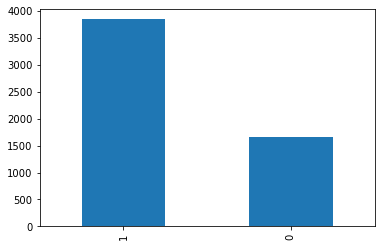

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   1668
1      1   3844


In [13]:
train_data['label'].value_counts()

1    3844
0    1668
Name: label, dtype: int64

In [14]:
print(train_data.isnull().sum())

document    1
label       0
dtype: int64


In [15]:
train_data.loc[train_data.document.isnull()]

,document,label
5782,NaN,1


In [16]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(len(train_data))

False
5511


In [17]:
text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거

'do you expect people to read the FAQ etc and actually accept hard atheism'

In [18]:
# https://www.unicode.org/charts/PDF/U3130.pdf
# ㄱ ~ ㅎ: 3131 ~ 314E
# ㅏ ~ ㅣ: 314F ~ 3163
# https://www.unicode.org/charts/PDF/UAC00.pdf
# 가 ~ 힣

In [19]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,document,label
3349,지금봐도야한거같아 년이었으면 얼마나파격적이었겠냐ㄷㄷㄷ,1
212,그냥 송위룡 얼굴이 개연성인데 뭘 더 바래여 잘생긴 얼굴 많이 써주세요,1
3297,동탄신도시 사는 김병준씨의 인생사와 견주어봐도 박빙인 영화우리나라 영화사상 이런 대...,1
8636,다 좋은데 배우를 성우로 쓸 것 같으면 이순재정도는 해줘야지 더빙이 진짜 너무하네 ...,0
6497,넷플릭스로 보다가 꺼버림 이걸 영화관에서 보고 있었다고 생각하니 끔찍,0


In [20]:
# 영어로만 작성된 리뷰도 삭제 됨
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

document    0
label       0
dtype: int64


In [21]:
train_data.loc[train_data.document.isnull()][:5]

,document,label


In [22]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

5511


In [23]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 2692


C:\Users\YH\Anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\YH\Anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\YH\Anaconda3\envs\rnn\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

### Tokenization

In [24]:
# 불용어 제거, 한국어의 조사, 접속사 등 -> 지속적으로 검토하면서 추가해서 삭제
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [25]:
# 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt
okt = Okt()
okt.morphs('2000년이후 최고의 서스펜스... 라고 했지만, 이걸 왜 봤을까', stem = True)

['2000년', '이후', '최고', '의', '서스펜스', '...', '라고', '하다', ',', '이', '걸', '왜', '보다']

In [26]:
# 불용어 제거
# 형태소 토큰화
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [27]:
print(X_train[:3])

[['지금', '보다', '야하다', '같다', '년', '이다', '얼마나', '파격', '적', '이다', 'ㄷㄷㄷ'], ['그냥', '송', '위룡', '얼굴', '개연', '성', '인데', '뭘', '더', '바', '래', '여', '잘생기다', '얼굴', '많이', '써주다'], ['동탄신도시', '살다', '김병준', '씨', '인생', '사오다', '견주어봐', '박빙', '인', '영화', '우리나라', '영화사', '상', '이렇다', '대작', '없다', '눕다', '김정은', '발딱', '스게', '연출', '캐스팅', '스토리', '라인', '인간', '논', '없다', '우주선', '이영화', '담다', '우주', '로', '쏘다', '올리다']]


In [28]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [29]:
### 정수 인코딩

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [31]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '있다': 4, '없다': 5, '좋다': 6, '너무': 7, '이다': 8, '스토리': 9, '같다': 10, '다': 11, '연기': 12, '에서': 13, '되다': 14, '로': 15, '배우': 16, '아니다': 17, '재밌다': 18, '만': 19, '적': 20, '것': 21, '진짜': 22, '긴장감': 23, '않다': 24, '평점': 25, '생각': 26, '시간': 27, '나오다': 28, '그': 29, '점': 30, '만들다': 31, '안': 32, '못': 33, '연출': 34, '게': 35, '나': 36, '사람': 37, '인': 38, '자다': 39, '내': 40, '정말': 41, '까지': 42, '감독': 43, '왜': 44, '고': 45, '그냥': 46, '보고': 47, '수': 48, '더': 49, '들다': 50, '하고': 51, '때': 52, '액션': 53, '정도': 54, '최고': 55, '가다': 56, '모르다': 57, '거': 58, '말': 59, '이렇다': 60, '그렇다': 61, '싶다': 62, '많다': 63, '하나': 64, '오다': 65, '주다': 66, '볼': 67, '느낌': 68, '요': 69, '재미있다': 70, '그리고': 71, '아쉽다': 72, '저': 73, '네': 74, '사냥': 75, '많이': 76, '뭐': 77, 'ㅋㅋ': 78, '작품': 79, '장면': 80, '성': 81, '이렇게': 82, '아깝다': 83, '끝': 84, '중': 85, '알다': 86, '넷플릭스': 87, '분': 88, '처음': 89, '영': 90, '내용': 91, '임': 92, '개': 93, '사랑': 94, '마지막': 95, '걸': 96, '감동': 97, '개봉': 98, '한국': 99, '총': 100, '님': 101, '아': 102, 'ㅠㅠ'

In [32]:
threshold = 3 # 빈도수가 3회 미만은 제거
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [33]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10160
등장 빈도가 2번 이하인 희귀 단어의 수: 6308
단어 집합에서 희귀 단어의 비율: 62.08661417322835
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.336872269460234


In [34]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3853


In [35]:
# 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환하는 정수 인코딩 과정에서 
# 이보다 큰 숫자가 부여된 단어들은 아예 계산하지 않음
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [36]:
print(X_train[:3])

[[182, 2, 265, 10, 158, 8, 401, 20, 8, 1619], [46, 1293, 1131, 382, 121, 81, 110, 325, 49, 749, 1132, 248, 626, 382, 76], [164, 482, 109, 38, 1, 358, 2614, 438, 60, 1215, 5, 3078, 34, 586, 9, 1065, 249, 2246, 5, 280, 458, 1374, 15, 459, 842]]


In [37]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 빈 샘플(Empty samples) 제거

In [38]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [39]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

5468
5468


In [40]:
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

2671
2671


### 패딩

리뷰의 최대 길이 : 302
리뷰의 평균 길이 : 18.036942209217266


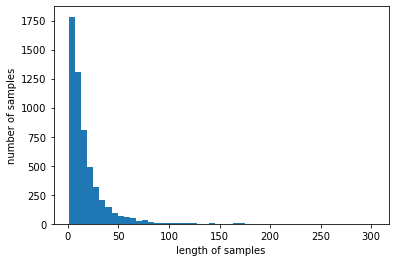

In [41]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [42]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [43]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 85.1865398683248


In [44]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## LSTM으로 네이버 영화 리뷰 감성 분류

In [45]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [46]:
T = X_train.shape[1]
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
i = Input(shape=(T,))
x = Embedding(vocab_size, 100)(i)
x = LSTM(128)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 100)           385300    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 502,677
Trainable params: 502,677
Non-trainable params: 0
_________________________________________________________________


In [47]:
X_train.shape[1]

30

In [48]:
# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후
# 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', 
                     verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, 
                    callbacks=[es, mc], batch_size=60, validation_split=0.2)

Train on 4374 samples, validate on 1094 samples
Epoch 1/15
4374/4374 [==============================] - 6s 1ms/sample - loss: 0.5637 - accuracy: 0.7112 - val_loss: 0.4086 - val_accuracy: 0.8117
Epoch 2/15
4374/4374 [==============================] - 4s 985us/sample - loss: 0.3222 - accuracy: 0.8722 - val_loss: 0.3878 - val_accuracy: 0.8227
Epoch 3/15
4374/4374 [==============================] - 4s 1ms/sample - loss: 0.2127 - accuracy: 0.9191 - val_loss: 0.4399 - val_accuracy: 0.8254
Epoch 4/15
4374/4374 [==============================] - 5s 1ms/sample - loss: 0.1515 - accuracy: 0.9449 - val_loss: 0.4894 - val_accuracy: 0.8190
Epoch 5/15
1800/4374 [===========>..................] - ETA: 2s - loss: 0.0878 - accuracy: 0.9722

In [ ]:
# loaded_model = load_model('best_model.h5')
# print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))